# Projet IA - Modèle d'Ising 2D - 2023/2024
Sorbonne Université - Master 1 - Physique Fondamentale et Applications

Guilherme Carvalho - Anatole Cremel-Schlemer - Panet Mathis

## Introduction - Code necessaire

In [1]:
# Importation des librairies
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, Accuracy, AUC
from tensorflow.keras.utils import plot_model
from numba import njit

# Dossier de travail
#file_dir = "./data/"
file_dir = "C:/Users/anato/Desktop/ising/data/data/"

In [2]:
# Importation des données fournis
def read_t(t,root="./", str_check=False):
  if not str_check :
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
  else :
    data = pickle.load(open(root+f'Ising2DFM_reSample_L40_T={t}.pkl','rb'))
  return np.unpackbits(data).astype(int).reshape(-1,1600)

data_all = read_t("All", file_dir, True)
data_label = pickle.load(open(file_dir+f'Ising2DFM_reSample_L40_T=All_labels.pkl','rb'))
print("Données importées")

Données importées


## Partie 1 : Génération de données

Nous allons voir dans cette partie comment générer des données avec le modèle d'Ising sans passer par l'algorithme de Metropolis. Un code C++ est aussi codé et accéléré mais il y a des petits bug sur l'enregistrement des données au niveau des bords. Le code est disponible sur le github.

### Génération python accéléré

La simulation est accélérée avec numba

#### Fonctions

In [3]:
@njit
def generer_tableau(ratio,size):
    nb = int(size*size*ratio)
    a = np.zeros(size*size)
    arr = np.arange(size*size)
    np.random.shuffle(arr)
    a[arr[:nb]]=1
    return a.reshape((size, size))


import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

@njit
def generer_tableau(ratio, size):
    nb = int(size * size * ratio)
    a = np.zeros(size * size)
    arr = np.arange(size * size)
    np.random.shuffle(arr)
    a[arr[:nb]] = 1
    return a.reshape((size, size))


@njit
def calcul_DE(tableau, x, y, size):
    if x == 0 or x == size - 1 or y == 0 or y == size - 1:
        extended_tab = np.zeros((size + 2, size + 2))
        extended_tab[1:size + 1, 1:size + 1] = tableau
        extended_tab[0, 1:size + 1] = tableau[-1]
        extended_tab[-1, 1:size + 1] = tableau[0]
        extended_tab[1:size + 1, 0] = tableau[:, size - 1]
        extended_tab[1:size + 1, size + 1] = tableau[:, 0]
        table_locale = extended_tab[x:x + 3, y:y + 3]
        o = table_locale[1, 1] * 2 - 1
        a = table_locale[0, 1] * 2 - 1
        b = table_locale[1, 0] * 2 - 1
        c = table_locale[1, 2] * 2 - 1
        d = table_locale[2, 1] * 2 - 1
    else:
        table_locale = tableau[x - 1:x + 2, y - 1:y + 2]
        o = table_locale[1, 1] * 2 - 1
        a = table_locale[0, 1] * 2 - 1
        b = table_locale[1, 0] * 2 - 1
        c = table_locale[1, 2] * 2 - 1
        d = table_locale[2, 1] * 2 - 1
    return 2 * o * (a + b + c + d)


@njit
def new_point_parallel(tableau, size, exp_values,nb_pas):
    for _ in prange(size * size * nb_pas):
        coordx = np.random.randint(size)
        coordy = np.random.randint(size)
        DE = calcul_DE(tableau, coordx, coordy, size)
        if test_precomputed(DE, exp_values):
            tableau[coordx, coordy] = not tableau[coordx, coordy]
    return tableau


@njit
def precomputed_exp_values(T):
    return np.array([np.exp(-4 / T), np.exp(-8 / T)])


@njit
def test_precomputed(DE, exp_values):
    if DE == 0 or DE == -4 or DE == -8:
        return True
    if DE == 4 or DE == 8:
        x = np.random.rand()
        return x < exp_values[int(DE / 4 - 1)]
    else:
        print("erreur, DE = ", DE)
        return False



@njit
def M(tableau, size):
    totplus = np.sum(tableau)

    return abs(-1 * (size * size - totplus) + totplus) / (size * size)


#### Génération

In [4]:
ratio_cases = 0.25

size = 40

tab = generer_tableau(ratio_cases, size)

nb_pas = 300 # un pas correspond à size * size tentatives d'ajouts de nouveaux points
nb_data = 50

T_liste = np.linspace(0.25, 4,16)


Mliste=[]
plt.figure(figsize=[40,40])

for i,T in tqdm(enumerate(T_liste)):
    exp_values = precomputed_exp_values(T)
    for dat in range(nb_data):
        tab = generer_tableau(ratio_cases, size)
        tab = new_point_parallel(tab, size, exp_values,nb_pas)
        Mliste.append(np.sum(tab))
    plt.subplot(10,10,i+1)
    plt.imshow(tab)
    plt.title('température = {:.3f}'.format(T))

plt.show()

0it [00:02, ?it/s]


SystemError: CPUDispatcher(<function new_point_parallel at 0x000001462A387A60>) returned a result with an error set

<Figure size 4000x4000 with 0 Axes>

#### plot

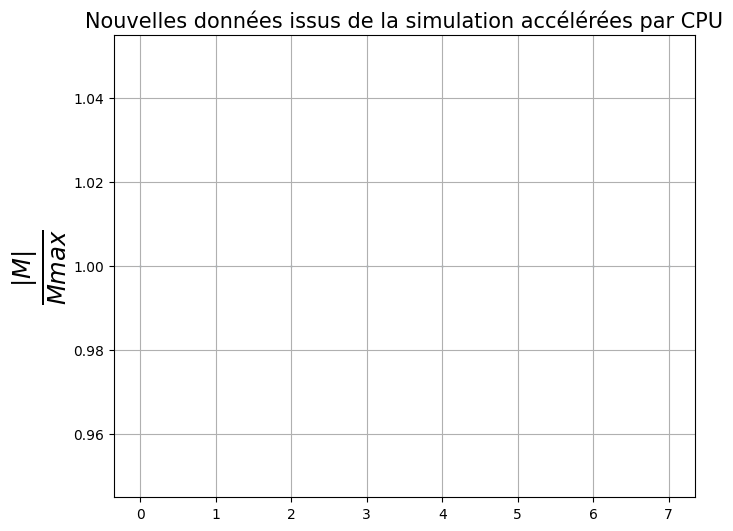

In [5]:
Mliste = (np.abs(np.array(Mliste)-800)*2)/1600

plt.figure(figsize=[7.5,6])
plt.scatter(np.arange(len(Mliste)),Mliste,s=0.2)
plt.ylabel(r'$\frac{|M|}{Mmax}$',size = 25)
plt.grid()
plt.title("Nouvelles données issus de la simulation accélérées par CPU",size = 15)
plt.show()

In [6]:
plt.plot(T_liste,Mliste.reshape(len(T_liste),nb_data).mean(axis=1),'x',label = "simulation N = 40 x40 ")

T = np.concatenate((np.linspace(0.1,2.2,100),np.linspace(2.2,2.26918478,100)))
x = (1-1/(np.sinh(2/T))**4)**(1/8)
plt.plot(list(T)+[2.269,3,3.5,3.7,4],list(x)+[0,0,0,0,0],label ="théorique  N→inf")


plt.xlabel('T')
plt.ylabel(r'$\frac{|M|}{Mmax}$')
plt.legend()
plt.grid()
plt.title('mean sur {} donnée par temperature'.format(nb_data))
plt.show()

ValueError: cannot reshape array of size 8 into shape (16,50)

### resultats et comparaison avec donnée du dataset

In [7]:
# Symétrisation des données (cf. Partie 2)

nom_temp = np.arange(0.25, 4.25, 0.25)

tot_data = np.empty((0,40,40))
tot_label = np.empty(0)

for T in nom_temp :
  tmp = read_t(T, file_dir)
  tot_data = np.concatenate((tot_data, tmp.reshape(tmp.shape[0], 40, 40)))
  tot_label = np.concatenate((tot_label, T*np.ones(tmp.shape[0])))

tot_data_sym = 2*np.abs(tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1) - 0.5)

In [8]:
# Importation des données générées

new_data = np.load("./new_data_accelerated.npy")
new_data.shape

(800,)

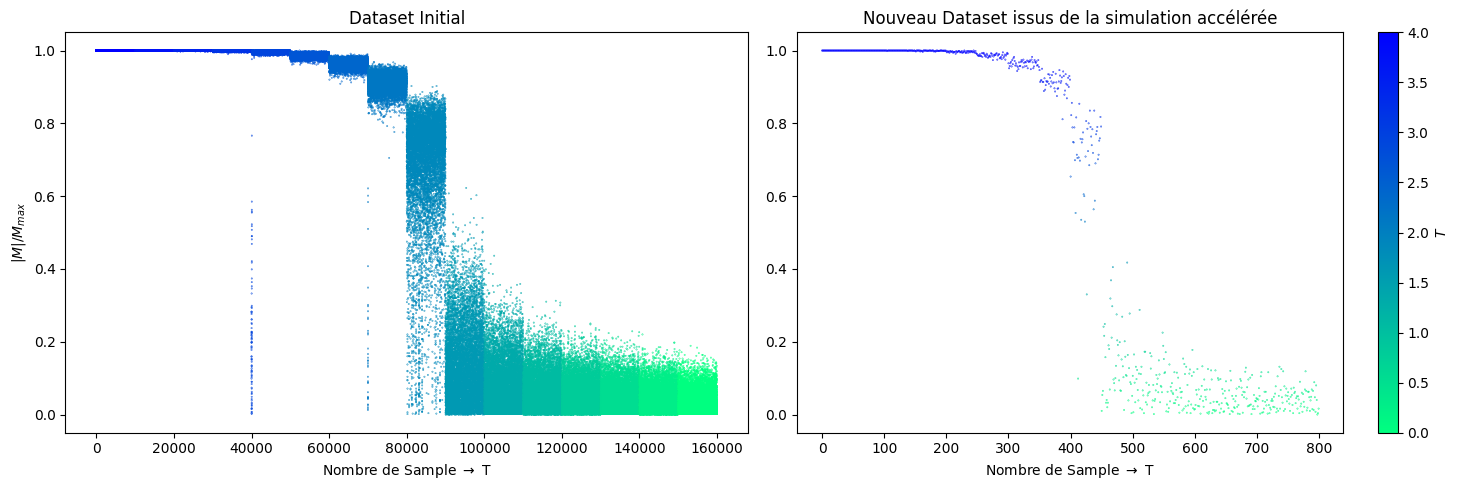

In [9]:
# Figure 1.6

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cmap = mpl.colormaps['winter']
axs[0].scatter(range(tot_data_sym.shape[0]), tot_data_sym, c=tot_label, cmap=cmap, s=0.1)
axs[0].set_ylabel(r'$|M|/M_{max}$')
axs[0].set_xlabel(r'Nombre de Sample $\rightarrow$ T')
axs[0].set_title(r'Dataset Initial')

cmap = mpl.colormaps['winter_r']
axs[1].scatter(range(new_data.shape[0]), new_data, c=new_data, cmap=cmap, s=0.1)
axs[1].set_xlabel(r'Nombre de Sample $\rightarrow$ T')
axs[1].set_title(r'Nouveau Dataset issus de la simulation accélérée')

plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=4), cmap=cmap), ax=axs[1], label=r'$T$')
plt.tight_layout()
plt.show()

## Partie 2 : Pré-traitement des données

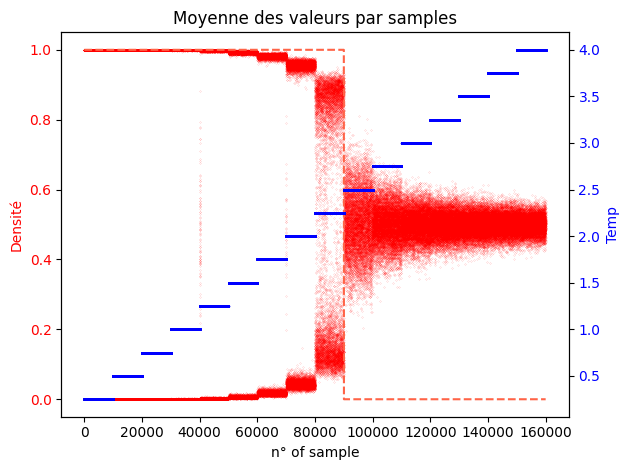

In [10]:
# Figure 2.1a
fig, ax1 = plt.subplots()

ax1.set_xlabel('n° of sample')
ax1.set_ylabel('Densité', color="red")
ax1.scatter(range(160000), tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1), s=.005, label="Mean value of samples", c="r")
ax1.plot(range(160000), data_label, "--", label="Labels", c='tomato')
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()

ax2.set_ylabel('Temp', color="b")
ax2.scatter(range(160000), tot_label, s=.1, label="Temps", c="b")
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title("Moyenne des valeurs par samples")

fig.tight_layout()
plt.show()

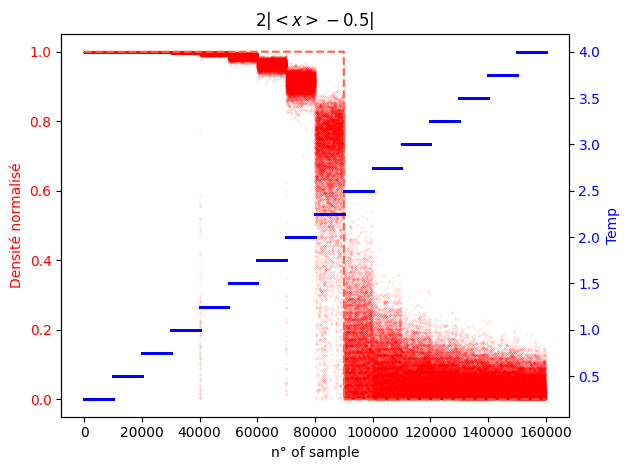

In [11]:
# Figure 2.1b
fig, ax1 = plt.subplots()

ax1.set_xlabel('n° of sample')
ax1.set_ylabel('Densité normalisé', color="red")
ax1.scatter(range(160000), tot_data_sym, s=.005, label="Mean value of samples", c="r")
ax1.plot(range(160000), data_label, "--", label="Labels", c='tomato')
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()

ax2.set_ylabel('Temp', color="b")
ax2.scatter(range(160000), tot_label, s=.1, label="Temps", c="b")
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title(r'$2 |<x> - 0.5|$')

fig.tight_layout()
plt.show()

## Partie 3 : Modèles classiques

### 3.1 Analyse par la magnétisation

In [ ]:
# Mpdèle naif
mean_temperature = np.mean(tot_label)
predictions = np.full_like(tot_label, mean_temperature)

# Calculate the mean squared error
mse = mean_squared_error(tot_label, predictions)
print("MSE:", mse)

In [ ]:
# Model linéaire sur les spins 
tot_data_sym_dim = np.c_[tot_data_sym.reshape(-1, 1), (tot_data_sym.reshape(-1, 1))**2, (tot_data_sym.reshape(-1, 1))**3, (tot_data_sym.reshape(-1, 1))**4]
X_train, X_test, y_train, y_test = train_test_split(tot_data_sym_dim, tot_label, test_size=0.2, random_state=42)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
predictions = linear_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("MSE :", mse)

In [ ]:
# Modèle de Forêt Aléatoire
T_C = 2.269

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(tot_data_sym.reshape(-1,1), tot_label, test_size=0.2, random_state=42)

# Créer le modèle de régression de forêt aléatoire
forest_model = RandomForestRegressor(max_depth=5, bootstrap=True, n_estimators=100)

# Adapter le modèle aux données d'entraînement
forest_model.fit(X_train, y_train)

# Prédire sur les données de test
predictions = forest_model.predict(X_test)

# Classe réelle
real_class = np.where(y_test>T_C, 1, 0)

# Classe prédite
pred_class = np.where(predictions>T_C, 1, 0)

# Calculer l'erreur quadratique moyenne
mse = mean_squared_error(y_test, predictions)
print("mse:", mse)

kde_data = pd.DataFrame({'T':tot_label, 'Sym':tot_data_sym})
xnew = np.linspace(0, 1, 100)
ynew = forest_model.predict(xnew.reshape(-1, 1))

In [ ]:
# Figure 3.1a
fig, ax = plt.subplots(figsize=(9, 5))
cmap = plt.get_cmap('winter', 16)

violinplots = []

for i in range(16):
    violinplot = ax.violinplot(
        kde_data[kde_data['T'] == nom_temp[i]]['Sym'],
        positions=[nom_temp[i]],
        showmeans=False,
        showextrema=True,
        widths=1.05,
        vert=False,
    )
    # Changer les couleurs en utilisant cmap
    violinplot['cmaxes'].set_color(cmap(i))
    violinplot['cmins'].set_color(cmap(i))
    violinplot['cbars'].set_color(cmap(i))
    for pc in violinplot['bodies']:
        pc.set_facecolor(cmap(i))
    # Changer l'épaisseur de ligne et l'opacité de la ligne
    violinplot['cmaxes'].set_alpha(0.4)
    violinplot['cmins'].set_alpha(0.4)
    violinplot['cbars'].set_alpha(0)
    
    violinplots.append(violinplot)

# Ajouter la ligne de la forêt aléatoire
ax.plot(xnew, ynew, color='r', linewidth=2, zorder=0, label="Forêt Aléatoire")

# Créer la légende
ax.legend()

# Ajouter des ticks mineurs à l'axe y
ax.set_yticks(nom_temp, minor=True)

ax.set_xlabel("Densité symétrisée")
ax.set_ylabel("Température")
ax.set_title(f"$T(d)$ : MSE = {mse:.3f}")

# Ajouter une grille aux ticks majeurs et mineurs
ax.grid(which='major', alpha=0.5, zorder=-1)
ax.grid(which='minor', alpha=0.2, linestyle='--', zorder=-1)

plt.tight_layout()
plt.show()

In [ ]:
# Figure 3.1b
conf_mat = confusion_matrix(real_class, pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues')
plt.show()

### 3.2 : Analyse par les spins

In [ ]:
# Modele naif

percentage_class_1 = data_label[data_label == 1].shape[0] / data_label.shape[0]
print(f"Pourcentage de classe 1 : {percentage_class_1*100:.2f}%")
percentage_class_0 = data_label[data_label == 0].shape[0] / data_label.shape[0]
print(f"Pourcentage de classe 0 : {percentage_class_0*100:.2f}%")

# Create a naive model
def naive_model():
    if np.random.uniform() < percentage_class_1:
        return 1
    else:
        return 0

# Test the naive model
predictions = [naive_model() for _ in range(data_label.shape[0])]

print("MSE:", mean_squared_error(data_label, predictions))
print("Accuracy:", np.mean(data_label == predictions))

In [ ]:
conf_mat = confusion_matrix(data_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues')
plt.savefig("random_matrix.png", dpi=300)
plt.show()

## Partie 4 : Réseaux de neurones

In [ ]:
# Creation des données pour le modèle de CNN
mean_val = tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1)
tot_data = tot_data.astype(np.uint8)

tot_data[mean_val > 0.5] = np.invert(tot_data[mean_val > 0.5])//255

In [ ]:

# Création du modèle de CNN
tot_data_cnn = tot_data.reshape(tot_data.shape[0], 40, 40, 1)

X_train, X_test, y_train, y_test = train_test_split(tot_data_cnn, data_label, test_size=0.2, random_state=42)

model = Sequential()
model.add(Conv2D(16, (5, 5), input_shape=(40, 40, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse', 'accuracy', Precision(), Recall(), AUC()])
model.summary()

In [ ]:
# Figure 4.1
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Entraînement du modèle de CNN
callback = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.2, callbacks = [callback])

In [ ]:
# Figure 4.2
plt.subplot(211)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Evolution')

plt.subplot(212)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Evolution')

plt.tight_layout()
plt.show()

In [ ]:
# Affichage des métriques
test_loss, test_mse, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test)
print('test loss', test_loss)
print('test mse', test_mse)
print('test accuracy', test_accuracy)
print('test precision', test_precision)
print('test recall', test_recall)
print('test auc', test_auc)

In [ ]:
# Figure 4.4
y_pred = model.predict(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Figure 4.5
y_pred.reshape(32000,)

y_pred_binary = (y_pred > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()

classes = ['Classe 0', 'Classe 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Prédit')
plt.ylabel('Réel')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.show()

## Générateur d'Images

### auto encodeur
Après de très nombreuses architectures et un succès limité et incomplet. Ce code permet d'entrainer un auto-encodeur à générer des images.
Le programme de post processing est pas au top mais je n'ai plus le temps de travailler dessus, sa performance optimum est au alentour de T=2.25

Vous trouverez ici une version partiel du programme.

Il faut aller voir le fichier Ising-Model_IA_M1/gen_new_method/auto-encoder   pour avoir  le programme complet./La simulation étant visiblement assez longue dans le modèle de base (130 epochs pour 16 températures).
Nous avons choisie de nous concentrer sur la température T = 2.25



pour voir les resultatsuce program normale il faut aller dans le fichier 
Ising-Model_IA_M1/gen_new_method/auto-encoder/result

Le programme est assez bugé sur la reconstruction d'image et ne génére pas directement une nouvelle images.

Pour cela il faudrait diagonaliser la matrice des vecteurs moyens afin de trouver le vecteur propre associé à une température.
ensuite appliquer une matrice de passage pour revenir dans l'espace latent et enfin reconstruire une nouvelle imageme

In [145]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### new dataset

In [146]:
# Creation des données pour le modèle de CNN
mean_val = tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1)
tot_data = tot_data.astype(np.uint8)

tot_data[mean_val > 0.5] = np.invert(tot_data[mean_val > 0.5])//255
# Création du modèle de CNN
tot_data_cnn = tot_data.reshape(tot_data.shape[0], 40, 40, 1)

X_train, X_test, y_train, y_test = train_test_split(tot_data_cnn, data_label, test_size=0.2, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [160000, 10000]

In [ ]:
lat =2048
tf.keras.backend.clear_session()
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
                
            layers.Input(shape=(40, 40, 1)),
            layers.Conv2D(2, (7, 7), activation='relu', padding='same'),
            layers.Conv2D(4, (3, 3),padding='same', activation='relu'),
            #40
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(8, (3, 3),padding='same', activation='relu'),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
            #20
            layers.MaxPooling2D(pool_size=(2, 2)),
            #10
            layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
            #8
            layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
            #6
            layers.Conv2D(128, (3, 3), activation='relu', padding='valid'), #tanh plus approprié
            #4
            layers.Reshape((lat,1,1)),
        ])
            
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(lat, 1, 1)),
            layers.Flatten(),
            layers.Dense(2000,activation= 'relu'),
            layers.Reshape((5,5,80)),
            layers.Conv2D(64, (3, 3),padding='same', activation='relu'),
            layers.UpSampling2D(size=(2, 2), interpolation="nearest"),
            layers.Conv2D(32, (3, 3),padding='same', activation='relu'),
            layers.UpSampling2D(size=(2, 2), interpolation="nearest"),
            layers.Conv2D(16, (3, 3),padding='same', activation='relu'),
            layers.UpSampling2D(size=(2, 2), interpolation="nearest"),
            layers.Conv2D(8, (3, 3),padding='same', activation='relu'),
            layers.Conv2D(1, (3, 3),padding='same', activation='sigmoid'),
    
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder()


# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse', 'accuracy', Precision(), Recall(), AUC()])




# Entraînement du modèle de CNN
callback = EarlyStopping(monitor='val_loss', patience=5)
    

    
X_train, X_test, y_train, y_test = train_test_split(tot_data_cnn, data_label, test_size=0.2, random_state=42)
    
history = autoencoder.fit(X_train, X_train, epochs=250, batch_size=264,
                  validation_split=0.2,callbacks = [callback])


In [ ]:
autoencoder.encoder.summary()

In [147]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2000)              4098000   
                                                                 
 reshape_1 (Reshape)         (None, 5, 5, 80)          0         
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 5, 64)          46144     
                                                                 
 up_sampling2d (UpSampling2D  (None, 10, 10, 64)       0         
 )                                                               
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 10, 32)        18464     
                                                      

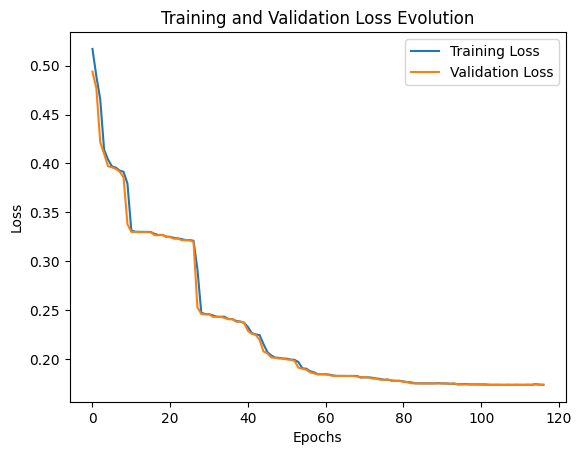

In [148]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Evolution')
plt.savefig('D:/ising/evoltution.jpg',dpi=300)
plt.show()

In [149]:
import time

def read_t(t,root="./", str_check=False):
  if not str_check :
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
  else :
    data = pickle.load(open(root+f'Ising2DFM_reSample_L40_T={t}.pkl','rb'))
  return np.unpackbits(data).astype(int).reshape(-1,1600)



Data_All = []
Data_Label = []
for T in np.arange(0.25,4.25,0.25):
    data_all = read_t('%.2f'%T, file_dir, True)
    data_all.shape
    
    mean_val = data_all.reshape(data_all.shape[0], 40*40).mean(axis=1)
    data_all = data_all.astype(np.uint8)
    
    data_all[mean_val > 0.5] = np.invert(data_all[mean_val > 0.5])//255
    data_all.shape
    data_label = np.array([T]*data_all.shape[0])
    Data_All.append(data_all)
    Data_Label.append(data_label)
    
Data_All = np.array(Data_All)
Data_Label = np.array(Data_Label)

In [150]:
Data_All.shape

(16, 10000, 1600)

In [151]:
Data_Label.shape

(16, 10000)

In [152]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(Data_All.reshape(160000,40,40,1), Data_Label.reshape(160000), test_size=0.2, random_state=42)

In [153]:

sample_image = X_test1[0:150]  # Remplacez 0 par l'indice de l'image que vous souhaitez tester

# Utilisez le modèle pour encoder l'image
encoded_imgs = autoencoder.encoder(sample_image).numpy()
print("Shape of encoded image:", encoded_imgs.shape)

# Utilisez le modèle pour décoder l'image
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
print("Shape of decoded image:", decoded_imgs.shape)


Shape of encoded image: (150, 2048, 1, 1)
Shape of decoded image: (150, 40, 40, 1)


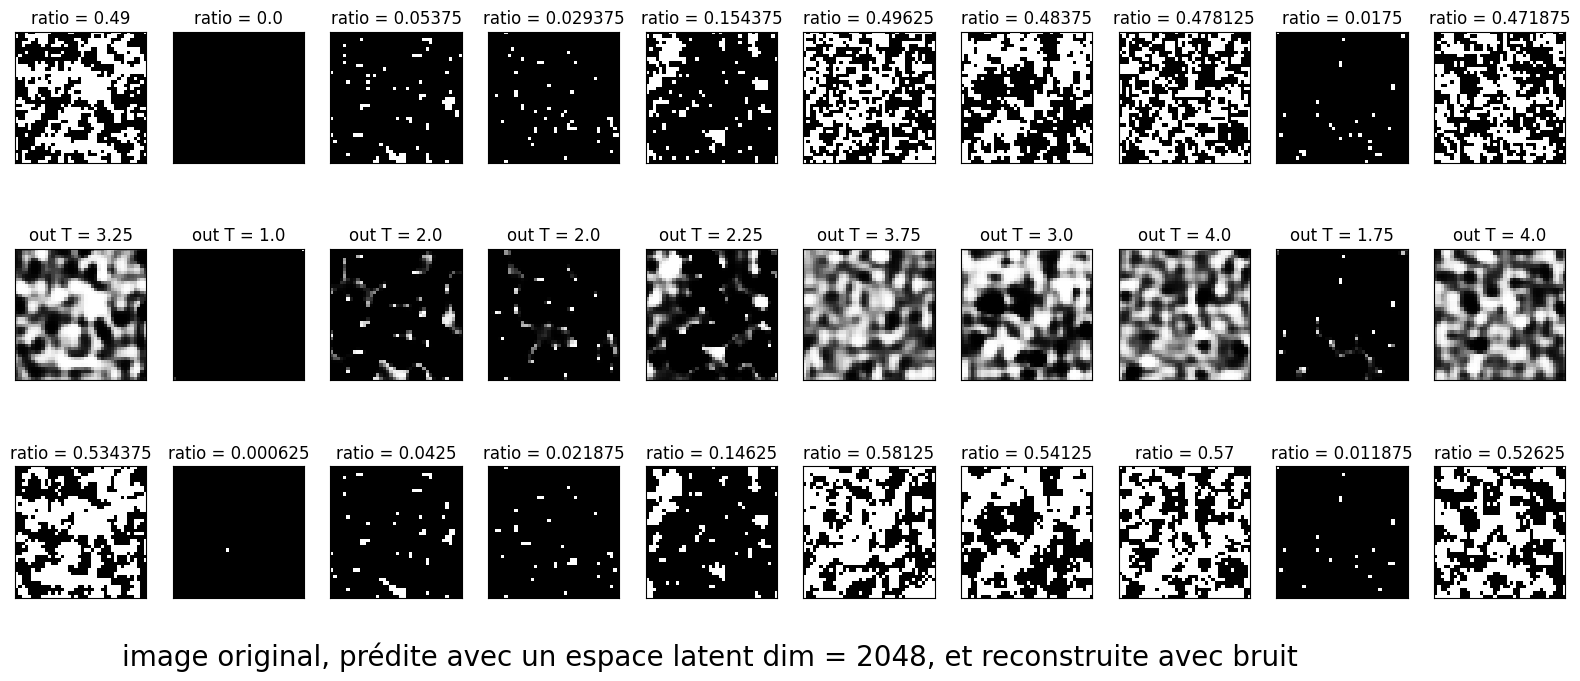

In [154]:
n = 10
plt.figure(figsize=(20, 8))
for j in range(n):
    img = np.copy(decoded_imgs[j])
    # display original
    ax = plt.subplot(3, n, j + 1)
    plt.imshow(X_test1[j])
    plt.title("ratio = {}".format(np.sum(X_test[j].reshape(1600))/1600))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    # display reconstruction
    ax = plt.subplot(3, n, j + 1 + n)
    plt.imshow(decoded_imgs[j])
    plt.title("out T = {}".format(y_test1[j]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    ax = plt.subplot(3, n, j + 1 + 2*n)
    img =  1.8*(img.reshape(1600)-0.1) + 1*np.random.normal(-0.1,0.2,1600) + 0.15*np.random.normal(0.2,2,1600) 
    sig = 1+((1)/(2))*((-1)/(1+np.exp(-(y_test1[j]-2.25)*16)))
    img[img<=sig]=0
    img[img>sig]=1
    plt.imshow(img.reshape(40,40))
    plt.title("ratio = {}".format(np.sum(img.reshape(1600))/1600))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.text(-400,60,'image original, prédite avec un espace latent dim = 2048, et reconstruite avec bruit',size = 20)
plt.savefig('D:/ising/triple_T .jpg',dpi=300)
plt.show()

In [155]:
encoded_imgs = np.empty((16,10,1000,2048))
for T in range(16):
    for i in range(10):
        
        dataT = Data_All[T].reshape(10000,40,40,1)
        sample_image = dataT[0:1000]
         
        a = autoencoder.encoder(sample_image).numpy().reshape(1000,2048)
        encoded_imgs[T][i] = a


In [156]:
b = encoded_imgs.reshape(16,10000,2048)

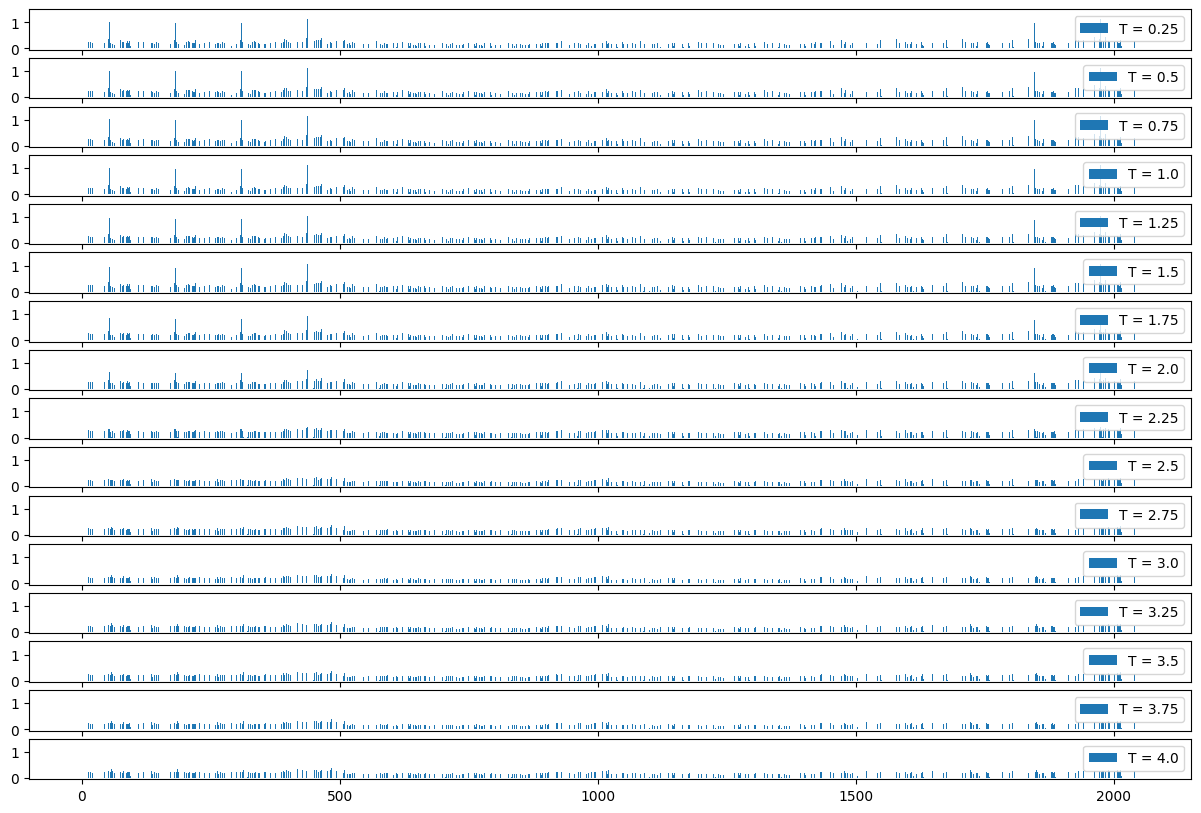

In [157]:
U = np.empty((16, 2048))
plt.figure(figsize=[15, 10])
# Boucle sur les différentes valeurs de T
for T in range(16):
    plt.subplot(16, 1, 1 + T)
    
    # Supposons que b est votre tableau de données
    c = b[T].reshape(10000, 2048)
    
    # Calculer la somme des colonnes et remplir la matrice U
    U[T, :] = np.mean(c, axis=0)
    
    # Tracer le graphique
    plt.bar(range(2048), U[T, :],label ='T = {}'.format(np.linspace(0.25,4,16)[T]))
    plt.ylim(-0.05,1.5)
    plt.legend(loc='upper right')

plt.savefig('D:/ising/yo .jpg',dpi=300)
plt.show()

In [158]:
label=[]
for i in np.linspace(0.25,4,16):
    label += [i]*10000
label = np.array(label)
label.shape

(160000,)

In [159]:
class Autoencoder2(Model):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(2048,)),
            layers.Flatten(),

            layers.Dense(16, activation='sigmoid'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(16,)),
            layers.Dense(16),
            layers.Dense(2048, activation='tanh'),
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder2 = Autoencoder2()

# Compile the model
autoencoder2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse', 'accuracy', Precision(), Recall(), AUC()])

# Entraînement du modèle de CNN
callback = EarlyStopping(monitor='val_loss', patience=5)

# Ajustez la forme de X_train2 ici
oo = encoded_imgs.reshape(160000,2048)

X_train2, X_test2, y_train2, y_test2 = train_test_split(oo,label, test_size=0.7, random_state=42)

history2 = autoencoder2.fit(X_train2, X_train2, epochs=200, batch_size=400,
                            validation_split=0.2, callbacks=[callback])


Epoch 1/200
96/96 [==============================] - 2s 15ms/step - loss: 0.4626 - mse: 0.0197 - accuracy: 0.0112 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - auc_5: 0.8417 - val_loss: 0.4248 - val_mse: 0.0203 - val_accuracy: 0.0020 - val_precision_5: 1.0000 - val_recall_5: 1.4916e-07 - val_auc_5: 0.8644
Epoch 2/200
96/96 [==============================] - 1s 9ms/step - loss: 0.4232 - mse: 0.0208 - accuracy: 0.0052 - precision_5: 0.6912 - recall_5: 5.6398e-04 - auc_5: 0.8652 - val_loss: 0.4214 - val_mse: 0.0210 - val_accuracy: 0.0052 - val_precision_5: 0.5759 - val_recall_5: 8.1978e-04 - val_auc_5: 0.8660
Epoch 3/200
96/96 [==============================] - 1s 9ms/step - loss: 0.4210 - mse: 0.0210 - accuracy: 0.0060 - precision_5: 0.7930 - recall_5: 0.0014 - auc_5: 0.8664 - val_loss: 0.4186 - val_mse: 0.0208 - val_accuracy: 0.0052 - val_precision_5: 0.9946 - val_recall_5: 0.0016 - val_auc_5: 0.8678
Epoch 4/200
96/96 [==============================] - 1s 9ms/step - loss: 0.4166 - 

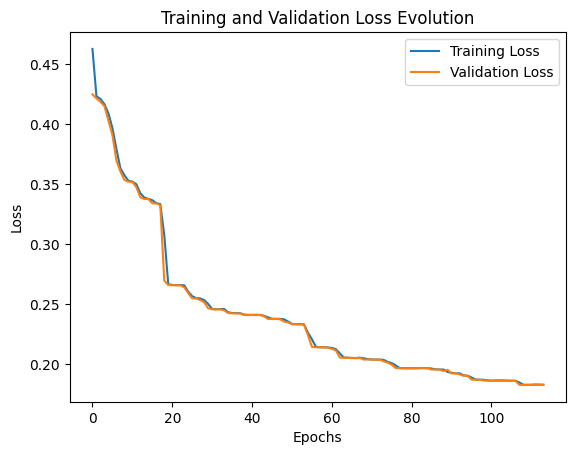

In [160]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Evolution')
plt.savefig('D:/ising/evoltution.jpg',dpi=300)
plt.show()

In [161]:
autoencoder2.encoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_13 (Dense)            (None, 16)                32784     
                                                                 
Total params: 32,784
Trainable params: 32,784
Non-trainable params: 0
_________________________________________________________________


In [162]:
autoencoder2.decoder.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 dense_15 (Dense)            (None, 2048)              34816     
                                                                 
Total params: 35,088
Trainable params: 35,088
Non-trainable params: 0
_________________________________________________________________


In [163]:
latent16 = autoencoder2.encoder(U).numpy()
print("Shape of encoded image:", latent16.shape)

Shape of encoded image: (16, 16)


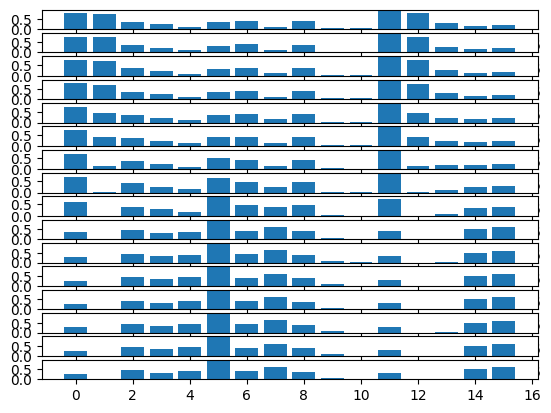

In [164]:
for i in range(16):
    plt.subplot(16,1,1+i)
    plt.bar(range(16),latent16[i])

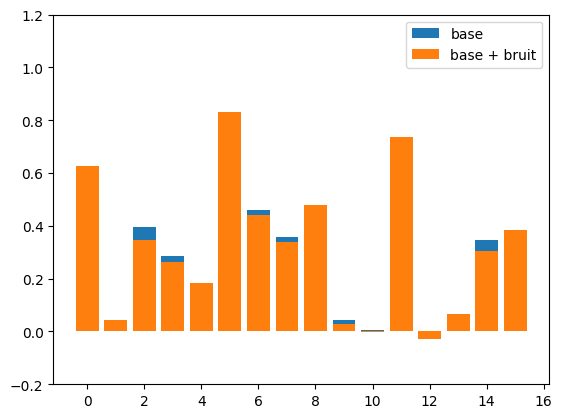

In [209]:
base = latent16[8]
noise = np.random.uniform(-0.05,0.05,16)
new = base + noise
a =plt.bar(range(16),base,label='base')
b =plt.bar(range(16),new,label='base + bruit')
plt.legend()
plt.ylim(-0.2,1.2)
plt.show()

In [210]:
new2048 = np.array(autoencoder2.decoder(new.reshape(1,16)))

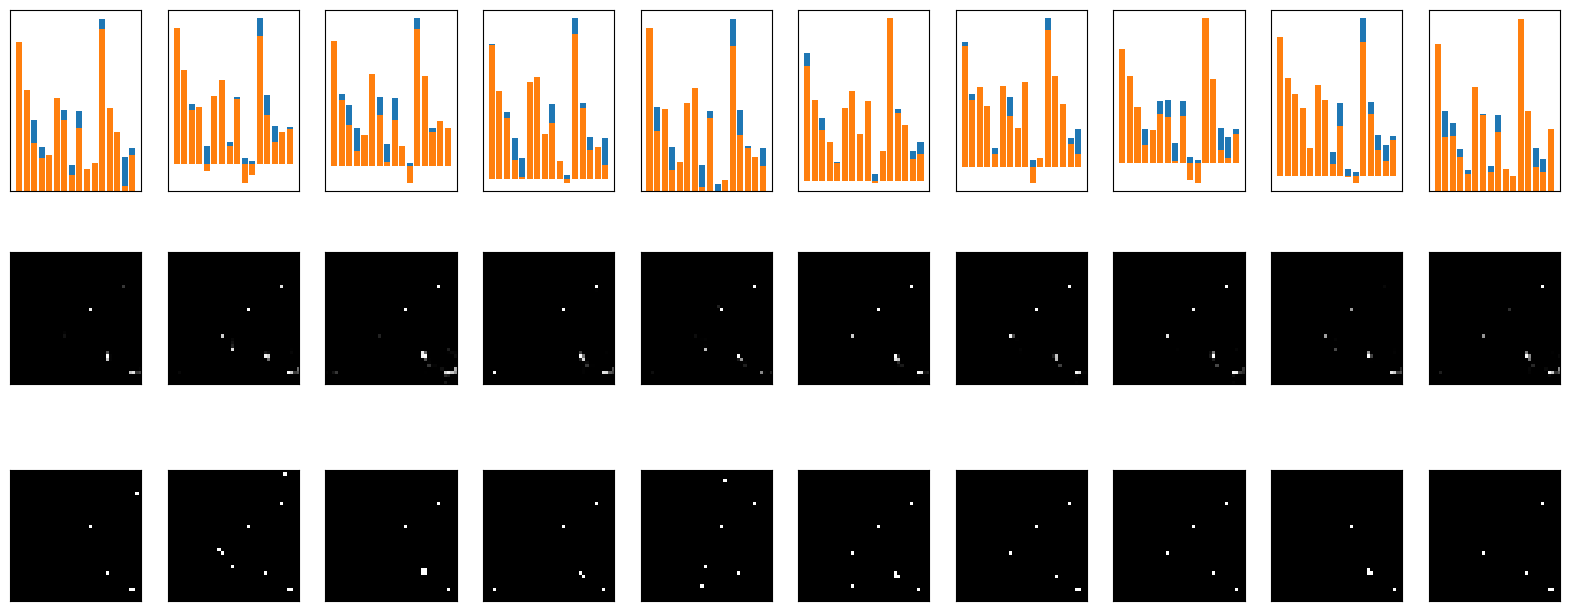

In [257]:
plt.figure(figsize=(20, 8))
j = 5
for i in range(10):
    
    base = latent16[j]
    noise = 0.5*np.random.uniform(-0.3,0.3,16)
    new = base + noise


    ax = plt.subplot(3,10,i+1)
    plt.bar(range(16),base)
    plt.bar(range(16),new)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    new2048 = np.array(autoencoder2.decoder(new.reshape(1,16)))
    
    ax = plt.subplot(3,10,i+1+10)
    img = np.array(autoencoder.decoder(new2048)).reshape(40,40)
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3,10,i+1+20)
    img =  1.8*(img.reshape(1600)-0.1) + 1*np.random.normal(-0.1,0.2,1600) + 0.15*np.random.normal(0.2,2,1600) 
    sig = 1+((1)/(2))*((-1)/(1+np.exp(-(1-2.25)*16)))
    img[img<=sig]=0
    img[img>sig]=1
    plt.imshow(img.reshape(40,40))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('D:/ising/T=4.jpg',dpi=300)

    

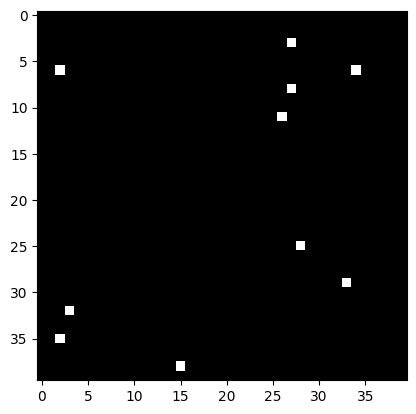

In [258]:
plt.imshow(Data_All[5][15].reshape(40,40))

In [250]:
Data_All[4][10].shape

(1600,)